# Getting Started with AuctionGym
## My Experiments Run

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from main import parse_config, instantiate_agents, instantiate_auction, simulation_run
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm
# from Bidder import *


In [2]:

import sys
modulenames = set(sys.modules) & set(globals())
allmodules = [sys.modules[name] for name in modulenames]
for module in allmodules:
    print(module.__name__)

sys
tqdm


In [3]:
config_file = '../config/my/SP_EpsilonGreedy-VS-Truthful.json'

graph_title = config_file

In [4]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values,\
num_runs, max_slots, embedding_size, embedding_var,\
obs_embedding_size = parse_config(config_file)

print('--- My Agents ---')

my_agents_names = []

i=0
for surplus in config['agents']:
    for copies in range(surplus['num_copies']):
        i+=1
        my_agents_names.append(f'{i}.{surplus["bidder"]["type"]}')
        # print(f'{i}) {agent["bidder"]["type"]}')
print(my_agents_names)

print()
print('--- Runs Number ---')
print(f"making {config['num_runs']} runs.\nFor each, {config['num_iter']} iterations, each for {config['rounds_per_iter']} episodes.")
print(f"\t\t -> total: {config['num_runs']*config['num_iter']*config['rounds_per_iter']}")

--- My Agents ---
['1.EpsilonGreedy', '2.TruthfulBidder', '3.TruthfulBidder', '4.TruthfulBidder', '5.TruthfulBidder']

--- Runs Number ---
making 3 runs.
For each, 10 iterations, each for 20 episodes.
		 -> total: 600


In [5]:
def run_repeated_auctions():
    # Placeholders for output
    auction_revenue = []
    social_welfare = []
    cumulative_surplus = []
    
    # Instantiate Agent and Auction objects
    agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
    
    agents_surpluseses = [[] for _ in range(len(agents))]

    # Instantiate Auction object
    auction, num_iter, rounds_per_iter, output_dir =\
        instantiate_auction(rng,
                            config,
                            agents2items,
                            agents2item_values,
                            agents,
                            max_slots,
                            embedding_size,
                            embedding_var,
                            obs_embedding_size)

    # Run repeated auctions
    # This logic is encoded in the `simulation_run()` method in main.py
    for i in tqdm(range(num_iter)):
        print(f'Iteration {i+1} of {num_iter}')

        # Simulate impression opportunities
        for _ in range(rounds_per_iter):
            auction.simulate_opportunity()

        # Log 'Gross utility' or welfare
        social_welfare.append(sum([agent.gross_utility for agent in auction.agents]))

        # Log 'Net utility' or surplus
        cumulative_surplus.append(sum([agent.net_utility for agent in auction.agents]))
        for agent_id, agent in enumerate(auction.agents):
            agents_surplus[agent_id].append(agent.net_utility)
        
        last_surplus = [surplus[-1] for surplus in agents_surplus]
        print(f"\teach agent's surplus: {last_surplus}")
        print(f"\tsums to {np.array(last_surplus).sum()}")
        # print(f"\tshould be equal to {cumulative_surplus[-1]}")
        # print(f"\t\t{(np.array(last_surplus).sum() == cumulative_surplus[-1])}")
        
        # Update agents (does nothing in this example, as we have truthful oracles)
        # Clear running metrics
        for agent_id, agent in enumerate(auction.agents):
            if(len(agent.logs)>0):
                agent.update(iteration=i)
                agent.clear_utility()
                agent.clear_logs()

        # Log revenue
        auction_revenue.append(auction.revenue)
        auction.clear_revenue()
        
    # Rescale metrics per auction round
    auction_revenue = np.array(auction_revenue) / rounds_per_iter
    social_welfare = np.array(social_welfare) / rounds_per_iter
    cumulative_surplus = np.array(cumulative_surplus) / rounds_per_iter
    
    return auction_revenue, social_welfare, cumulative_surplus, agents_surplus

In [6]:
num_participants_2_metrics = run_repeated_auctions()
# print(num_participants_2_metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration 1 of 10
	each agent's surplus: [-1.292721514898255, -2.181403480992494, -3.186669493810425, -0.03, -1.9490455773941626]
	sums to -8.639840067095337
EpsilonGreedy: update


Truthful Learnt 2:  53%|█████▎    | 8726/16384 [00:24<00:21, 351.64it/s]
c:\Users\bona1\VSCode_projects\amazon_auction-gym\auction-gym\src\Models.py:44: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3281.)
  P = (1 + torch.exp(1 - X.matmul(self.m[item, :].T))) ** (-1)


Stopping at Epoch 8726


Truthful Learnt 3:  46%|████▌     | 7480/16384 [00:16<00:19, 454.18it/s]


Stopping at Epoch 7480


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:37<00:00, 442.51it/s]


Iteration 2 of 10
	each agent's surplus: [0.0, -0.9880850694128923, -3.1093239515004427, -0.9805925099409692, -6.654180770894967]
	sums to -11.73218230174927
EpsilonGreedy: update


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:40<00:00, 408.61it/s]


Iteration 3 of 10
	each agent's surplus: [0.0, -2.841202094881152, -1.0515791643422583, -5.394462680806015, -0.9388097778689103]
	sums to -10.226053717898335
EpsilonGreedy: update


Truthful Learnt 2:  63%|██████▎   | 10273/16384 [00:35<00:21, 289.15it/s]


Stopping at Epoch 10273


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:48<00:00, 337.93it/s]


Iteration 4 of 10
	each agent's surplus: [0.8485445454411714, -1.0126595929061388, -0.9683656279779664, 1.07276723866946, -0.8671263385326066]
	sums to -0.9268397753060803
EpsilonGreedy: update


Truthful Learnt 3:  36%|███▌      | 5919/16384 [00:17<00:30, 340.15it/s]


Stopping at Epoch 5919


Truthful Learnt 4:  34%|███▎      | 5515/16384 [00:18<00:36, 300.49it/s]


Stopping at Epoch 5515


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:44<00:00, 370.52it/s]


Iteration 5 of 10
	each agent's surplus: [1.984289745923694, -0.9945973871901436, 0.0, 1.079699322249915, -0.3863890216965463]
	sums to 1.683002659286919
EpsilonGreedy: update


Truthful Learnt 4:  79%|███████▊  | 12884/16384 [00:26<00:07, 479.93it/s]


Stopping at Epoch 12884


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:36<00:00, 448.41it/s]


Iteration 6 of 10
	each agent's surplus: [3.5113187642053427, 1.3360938513892875, 0.667132104476884, 2.3157682881857715, 0.0]
	sums to 7.830313008257285
EpsilonGreedy: update


Truthful Learnt 2:  41%|████      | 6654/16384 [00:15<00:22, 427.58it/s]


Stopping at Epoch 6654


Truthful Learnt 4:  47%|████▋     | 7645/16384 [00:15<00:18, 482.20it/s]


Stopping at Epoch 7645
Iteration 7 of 10
	each agent's surplus: [0.9732416437113631, -0.06114761321568208, -0.0013414841198885396, 0.47983765268828793, 0.0]
	sums to 1.3905901990640803
EpsilonGreedy: update


Truthful Learnt 2:  19%|█▊        | 3032/16384 [00:07<00:32, 411.82it/s]


Stopping at Epoch 3032


Truthful Learnt 3:  74%|███████▍  | 12143/16384 [00:32<00:11, 370.10it/s]


Stopping at Epoch 12143


Truthful Learnt 4:  40%|███▉      | 6490/16384 [00:16<00:25, 389.61it/s]


Stopping at Epoch 6490
Iteration 8 of 10
	each agent's surplus: [5.493842551029819, -0.3, -0.21813487230756465, 0.4820048267505852, 0.0]
	sums to 5.4577125054728395
EpsilonGreedy: update


Truthful Learnt 4:  58%|█████▊    | 9515/16384 [00:24<00:17, 388.38it/s]


Stopping at Epoch 9515
Iteration 9 of 10
	each agent's surplus: [4.5107991139712444, -0.00025030220709284156, -0.0003947279151525118, 0.7787989511303424, -1.4682606914840507e-05]
	sums to 5.288938352372427
EpsilonGreedy: update


Truthful Learnt 2:  41%|████      | 6754/16384 [00:14<00:20, 461.04it/s]


Stopping at Epoch 6754


Truthful Learnt 4:  60%|█████▉    | 9760/16384 [00:26<00:17, 371.01it/s]


Stopping at Epoch 9760
Iteration 10 of 10
	each agent's surplus: [1.0836374748502722, -0.0014708203407876857, -0.1569490783774702, 0.906617197736382, 0.0]
	sums to 1.8318347738683964
EpsilonGreedy: update


Truthful Learnt 2:  48%|████▊     | 7894/16384 [00:23<00:25, 336.85it/s]


Stopping at Epoch 7894


Truthful Learnt 3:  90%|█████████ | 14794/16384 [00:42<00:04, 346.24it/s]


Stopping at Epoch 14794


Truthful Learnt 4:  42%|████▏     | 6838/16384 [00:24<00:33, 284.71it/s]

Stopping at Epoch 6838


In [7]:
r, w, s, a_s = num_participants_2_metrics
for i, surplus in enumerate(a_s):
    print(f'{my_agents_names[i]} surplus: {np.array(surplus).sum()}')


1.EpsilonGreedy surplus: 17.112952324234648
2.TruthfulBidder surplus: -7.044722509757095
3.TruthfulBidder surplus: -8.025626295874284
4.TruthfulBidder surplus: 0.7104382866637594
5.TruthfulBidder surplus: -10.795566168994108


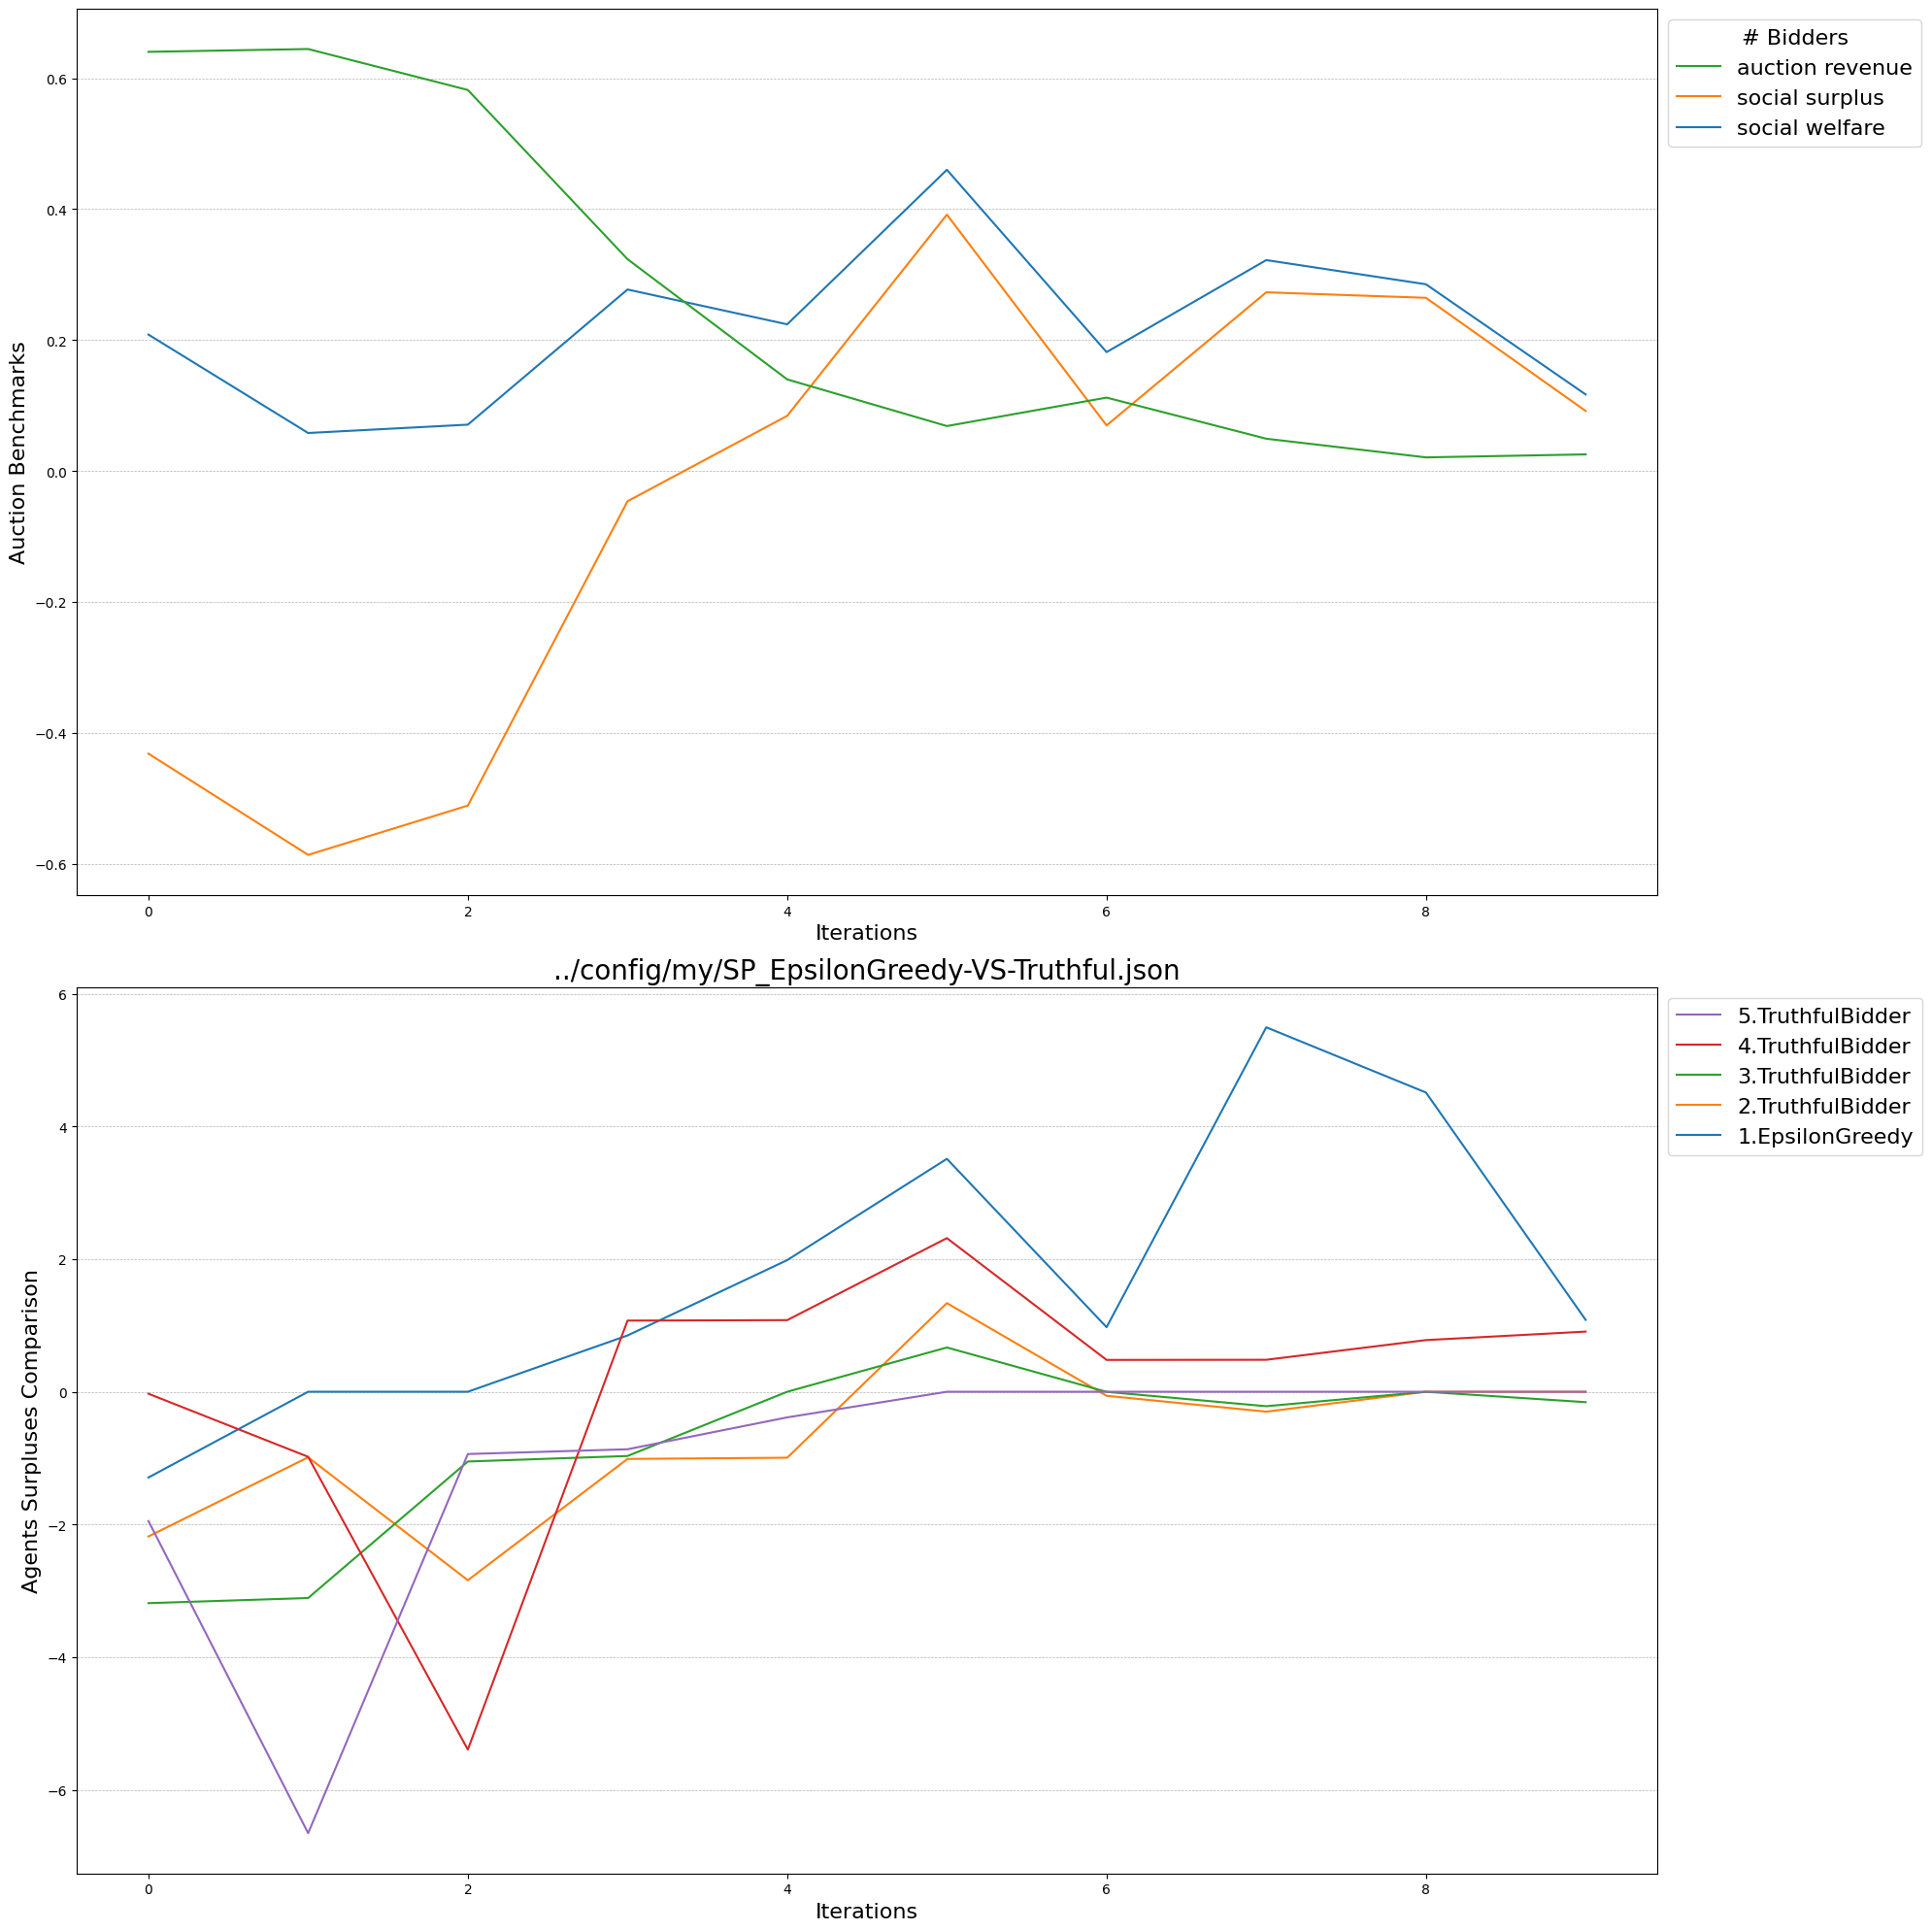

In [22]:
fontsize=16
fig, axes = plt.subplots(2,1, sharey='row', figsize=(20,20))

# for num_participants_per_round, (revenue, welfare, surplus) in num_participants_2_metrics.items():    
#     axes[0].plot(welfare, label=f'{num_participants_per_round}')
#     axes[1].plot(surplus, label=f'{num_participants_per_round}')
#     axes[2].plot(revenue, label=f'{num_participants_per_round}')

graph_auction_bench = axes[0]
graph_surpluses = axes[1]

revenue, welfare, surplus, agents_surplus = num_participants_2_metrics   
graph_auction_bench.plot(welfare, label=f'social welfare')
graph_auction_bench.plot(surplus, label=f'social surplus')
graph_auction_bench.plot(revenue, label=f'auction revenue')

for i, surplus in enumerate(agents_surplus):
    graph_surpluses.plot(surplus, label=my_agents_names[i])


graph_surpluses.set_title(graph_title, fontsize=fontsize+4)

for i in range(len(axes)):
    axes[i].set_xlabel('Iterations', fontsize=fontsize)
    axes[i].set_xticks(list(range(0,len(revenue),2)))
    axes[i].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

    
graph_auction_bench.set_ylabel('Auction Benchmarks', fontsize=fontsize)
graph_surpluses.set_ylabel('Agents Surpluses Comparison', fontsize=fontsize)

handles, labels = graph_auction_bench.get_legend_handles_labels()
legend = graph_auction_bench.legend(reversed(handles),
                   reversed(labels),
                   loc='upper left',
                   bbox_to_anchor=(1.0, 1.0),
                   fontsize=fontsize)
legend.set_title('# Bidders', prop={'size': fontsize})

handles2, labels2 = graph_surpluses.get_legend_handles_labels()
legend2 = graph_surpluses.legend(reversed(handles2),
                         reversed(labels2),
                         loc='upper left',
                         bbox_to_anchor=(1.0, 1.0),
                         fontsize=fontsize)

fig.tight_layout()

plt.show()